<a href="https://colab.research.google.com/github/ekgren/physical-cellular-automata/blob/main/colabs/Physical_Cellular_Automata_Simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physical Cellular Automata - Simple notebook
The simple notebook is a notebook with a simple Physical CA.

**Disclaimer:** The underlying repository physical-cellular-automata https://github.com/ekgren/physical-cellular-automata will continually undergo changes that might break copies of this notebook.  

**Authors:**  
Ariel Ekgren  
https://github.com/ekgren  
https://twitter.com/ArYoMo  

Amaru Cuba Gyllensten  
https://github.com/apsod  



In [1]:
!git clone https://github.com/ekgren/physical-cellular-automata.git
%pip install -e ./physical-cellular-automata
import sys
sys.path.insert(0,'./physical-cellular-automata/')

Cloning into 'physical-cellular-automata'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 49 (delta 13), reused 39 (delta 7), pack-reused 0
Unpacking objects: 100% (49/49), done.
Obtaining file:///content/physical-cellular-automata
  Running setup.py develop for phyca


In [2]:
!git -C ./physical-cellular-automata/ pull

Already up to date.


In [3]:
import os

import numpy as np
import torch
from torch.nn.functional import softmax
import PIL
from PIL import ImageDraw, ImageFont
from matplotlib import pyplot as pl
from tqdm import trange
from IPython.display import clear_output
os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter

import phyca

device = 'cuda'

In [4]:
# Utils
def display_img(input, size=1., return_img=False):
    """ Assumes tensor values in the range [0, 1] """
    with torch.no_grad():
        batch_size, num_channels, height, width = input.shape
        img = torch.nn.functional.interpolate(input, (int(size*height), int(size*width)), mode='area')
        img_show = img.cpu()[0].transpose(0, 1).transpose(1, 2)
        img_out = (img_show * 255).clamp(0, 255).to(torch.uint8)
        img_out = PIL.Image.fromarray(img_out.cpu().numpy(), 'RGB')
        if return_img:
            return img_out
        display(img_out)
        pl.show()

def step(mass, momentum, force, A, kernel, dt=1., temp=1e-1):
    # Update force
    kernel_constant = kernel.abs().sum()**-1.
    force_norm = force.norm(p=2, dim=0, keepdim=True)
    force_delta = phyca.conv_pad(A*mass + force_norm, kernel).permute(1, 0, 2, 3) - force
    force = force + force_delta * kernel_constant

    # Update momentum
    momentum = torch.where(mass < 1e-8, momentum.new_zeros(()), momentum + force * dt)
    velocity = torch.where(mass < 1e-8, momentum.new_zeros(()), momentum / mass)

    # Update mass
    propagation = torch.einsum('dn,nchw->cdhw', directions, velocity)
    propagation = softmax(propagation.mul(temp), dim=1)
    propagation = torch.where(propagation <= 0., propagation.new_zeros(()),  propagation)
    
    mass_tot = mass.sum()
    mass_propagation = mass * propagation
    momentum_propagation = momentum * propagation

    mass = phyca.conv_pad(mass_propagation, moves)
    momentum = phyca.conv_pad(momentum_propagation, moves)
    mass = mass_tot * mass / mass.sum()

    return mass, momentum, force

# Simple Physical Cellular Automata - making animation

In [ ]:
# Plot
plt_size   = 2
vid_size   = 2
vid_step   = 5
iter       = 3000

# Parameters
size       = 128 + 1  # +1 for symmetry
A          = -1.      # Acceleration constant A = [m / s^2]
mass_const = 1e+3     # Mass
dt         = 1.
temp       = 5e-2

# Kernel parameters
pow        = 0.2

with torch.inference_mode():
    with FFMPEG_VideoWriter(size=(3*size*vid_size, 2*size*vid_size), filename='movie.mp4', fps=20.0) as vid:
        
        # Create direction and move tensors
        directions = phyca.make_directions(device)
        moves = phyca.make_moves(device)
                
        # Create kernel
        kernel = phyca.make_kernel(pow=0.2, device=device)
        
        # Create quantities
        mass = torch.rand(1, 1, size, size, requires_grad=False, device=device)      # mass = [kg]
        force = torch.zeros(2, 1, size, size, requires_grad=False, device=device)    # force = [kg * m / s^2]
        momentum = torch.zeros(2, 1, size, size, requires_grad=False, device=device) # momentum = [kg * m / s]

        for i in trange(iter):
            mass, momentum, force = step(mass, momentum, force, A, kernel, dt, temp)

            if i % vid_step == 0:
                # Create images
                img_outs = []
                img1 = phyca.min_max(mass.repeat(1, 3, 1, 1).log1p())
                img2 = phyca.min_max(force[0, :, :, :].repeat(1, 3, 1, 1))
                img3 = phyca.min_max(force[1, :, :, :].repeat(1, 3, 1, 1))
                img_outs.append(torch.cat([img1, img2, img3], dim=3))

                force_norm = force.norm(p=2, dim=0, keepdim=True)
                momentum_norm = force.norm(p=2, dim=0, keepdim=True)
                img1 = phyca.min_max(torch.cat([phyca.min_max(mass.log1p()),
                                                phyca.min_max(force_norm.log1p()),
                                                phyca.min_max(momentum_norm.log1p())], dim=1))
                img2 = phyca.min_max(momentum[0, :, :, :].repeat(1, 3, 1, 1))
                img3 = phyca.min_max(momentum[1, :, :, :].repeat(1, 3, 1, 1))
                img_outs.append(torch.cat([img1, img2, img3], dim=3))

                img_out = torch.cat(img_outs, dim=2)
                img = display_img(img_out, size=plt_size, return_img=True)
                vid.write_frame(img)

mvp.ipython_display('movie.mp4')

# Simple Physical Cellular Automata - making image

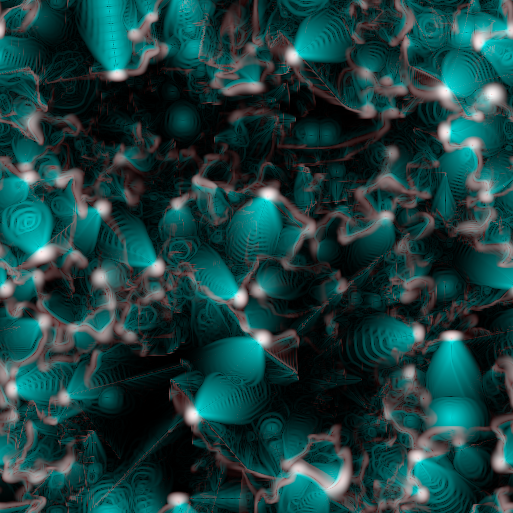

100%|██████████| 3000/3000 [00:08<00:00, 352.40it/s]


In [6]:
# Plot
plt_size = 1
img_step = 500
iter     = 3000

# Parameters
size     = 512 + 1  # +1 for symmetry
A        = -1.      # Acceleration constant A = [m / s^2]
mass_mul = 1e+3     # Mass multiplier
dt       = 3e-1
temp     = 1e-1


with torch.inference_mode():
        
    # Create direction and move tensors
    directions = phyca.make_directions(device)
    moves = phyca.make_moves(device)
            
    # Create kernel
    kernel = phyca.make_kernel(x_mul= 1.0, y_mul= 1.0, pow=0.2, swap=False, device=device)
    
    # Create quantities
    mass = torch.rand(1, 1, size, size, requires_grad=False, device=device) * mass_mul  # mass = [kg]
    force = torch.zeros(2, 1, size, size, requires_grad=False, device=device)           # force = [kg * m / s^2]
    momentum = torch.zeros(2, 1, size, size, requires_grad=False, device=device)        # momentum = [kg * m / s]

    for i in trange(iter):
        mass, momentum, force = step(mass, momentum, force, A, kernel, dt, temp)

        if i % img_step == 0:
            # Create images
            clear_output(True)
            force_norm = force.norm(p=2, dim=0, keepdim=True)
            momentum_norm = force.norm(p=2, dim=0, keepdim=True)
            img_out = phyca.min_max(torch.cat([phyca.min_max(mass.log1p()),
                                               phyca.min_max(force_norm.log1p()),
                                               phyca.min_max(momentum_norm.log1p())], dim=1))
            img = display_img(img_out, size=plt_size, return_img=False)